In [2]:
import yfinance as yf
import pandas as pd
from tqdm import tqdm
from typing import Literal
import time, random
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
index_df = pd.read_csv('index_composition.csv', index_col = 'Ticker')
sector_list = index_df['Sector']
input_date = '29/10/2024'

date = pd.to_datetime(input_date, dayfirst=True).tz_localize(None)
range_dict = {
    '1W': date - pd.Timedelta(days=7),                  # 1 Week ago
    '1M': date - pd.Timedelta(days=30),                 # 1 Month ago
    '3M': date - pd.Timedelta(days=30*3),               # 3 Month ago
    '6M': date - pd.Timedelta(days=30*6),               # 6 Month ago
    '1Y': date - pd.Timedelta(days=360),                # 1 Year ago
    '5Y': date - pd.Timedelta(days=360 * 5),            # 5 Years ago
    '10Y': date - pd.Timedelta(days=360 * 10),          # 10 Years ago
    'YTD': pd.Timestamp(year=date.year, month=1, day=1) # Year-to-date
}

In [6]:
def avg_return(history: pd.Series, timeperiod: int = 255) -> float:
    """
    #### Description:
    Calculate the average return of a financial instrument over a specified time period.

    #### Parameters:
    - history (pd.Series): Time series data representing the historical prices or returns of the financial instrument.
    - timeperiod (int, optional): The number of periods to consider for calculating the average return. Default is 255.

    #### Returns:
    - float: Average return over the specified time period.
    """
    returns = history.pct_change().dropna()
    return (1 + returns.sum()) ** (timeperiod/returns.count()) - 1

In [11]:
# Fetching and reating a DataFrame to store historical prices for each asset
history_df = pd.DataFrame()
for ticker in tqdm(index_df.index):
    history = yf.Ticker(ticker).history('max')
    history_df[ticker] = history['Close']
    time.sleep(random.uniform(0, 0.1))
history_df = history_df.resample('D').last().ffill()
history_df = history_df.tz_localize(None)
history_df = history_df.dropna(axis=1, how='all')

100%|██████████| 40/40 [00:15<00:00,  2.53it/s]


In [41]:
history_df = pd.DataFrame({
    ticker: yf.Ticker(ticker).history('max')['Close'] 
    for ticker in tqdm(index_df.index)
    if not time.sleep(random.uniform(0, 0.1))
}).dropna(axis=1, how='all')
history_df.index = history_df.index.normalize()
history_df = history_df.tz_localize(None)

100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


In [22]:
x_key = '1Y'
y_key = '5Y'

df = pd.DataFrame()
for ticker in index_df.index:
    x_value = range_dict[x_key]
    y_value = range_dict[y_key]

    x_return = avg_return(history_df.loc[x_value:, ticker])
    y_return = avg_return(history_df.loc[y_value:, ticker])

    df.at[ticker, x_key] = x_return
    df.at[ticker, y_key] = y_return

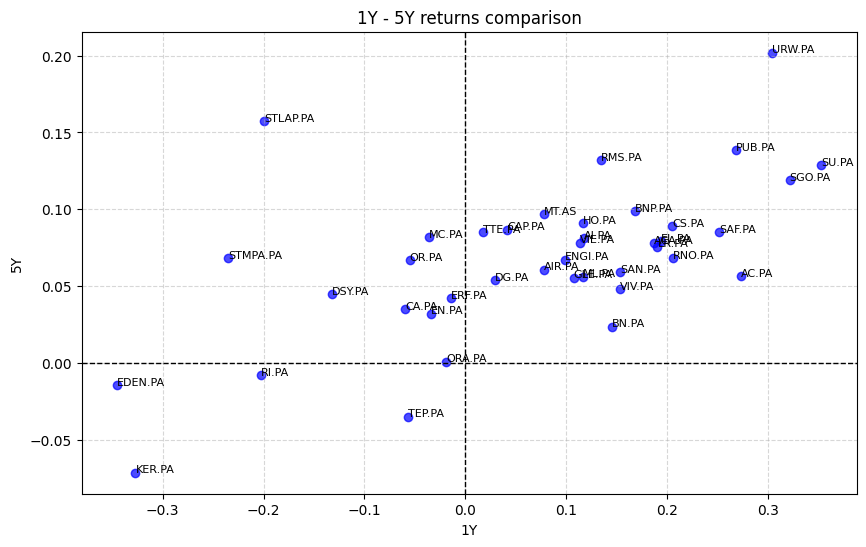

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(df[x_key], df[y_key], color='blue', alpha=0.7)

# Dashed lines at the origin
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(0, color='black', linestyle='--', linewidth=1)

# Adding labels and title
plt.xlabel(x_key)
plt.ylabel(y_key)
plt.title(f'{x_key} - {y_key} returns comparison')
plt.grid(True, linestyle='--', alpha=0.5)

# Annotate each point
for i, txt in enumerate(df.index):
    plt.annotate(txt, (df[x_key].iloc[i], df[y_key].iloc[i]), fontsize=8, color='black')

plt.show()